# Heart Attack Prediction modeling on a randomly generated data:

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
h_a_df = pd.read_csv("/content/drive/MyDrive/ML /heart_attack_prediction/Dataset/heart_attack_prediction_dataset.csv")
h_a_df.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


## 1. Data preprocessing and feature engineering

In [4]:
h_a_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [5]:
# Determine the number of unique values in each column.
cat_features = h_a_df.dtypes[h_a_df.dtypes==object].index.tolist()
h_a_df[cat_features].nunique()

Patient ID        8763
Sex                  2
Blood Pressure    3915
Diet                 3
Country             20
Continent            6
Hemisphere           2
dtype: int64

In [6]:
# Check the country distribution
unique_countries = h_a_df["Country"].value_counts()
unique_countries

Germany           477
Argentina         471
Brazil            462
United Kingdom    457
Australia         449
Nigeria           448
France            446
Canada            440
China             436
New Zealand       435
Japan             433
Italy             431
Spain             430
Colombia          429
Thailand          428
South Africa      425
Vietnam           425
United States     420
India             412
South Korea       409
Name: Country, dtype: int64

In [25]:
# Split the Blood prssure into two columns systolic, diastolic
h_a_df[["systolic", "diastolic"]] = h_a_df["Blood Pressure"].str.split("/", expand=True)
h_a_df["systolic"] = h_a_df["systolic"].astype("float")
h_a_df["diastolic"] = h_a_df["diastolic"].astype("float")

In [26]:
h_a_df.drop(columns = ["Patient ID", "Blood Pressure", "Country"], index=1, inplace=True)

In [27]:
# Convert categorical data into numeric data
numeric_df = pd.get_dummies(h_a_df, dtype="float")
numeric_df = numeric_df.astype("float")
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8762 entries, 0 to 8762
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8762 non-null   float64
 1   Cholesterol                      8762 non-null   float64
 2   Heart Rate                       8762 non-null   float64
 3   Diabetes                         8762 non-null   float64
 4   Family History                   8762 non-null   float64
 5   Smoking                          8762 non-null   float64
 6   Obesity                          8762 non-null   float64
 7   Alcohol Consumption              8762 non-null   float64
 8   Exercise Hours Per Week          8762 non-null   float64
 9   Previous Heart Problems          8762 non-null   float64
 10  Medication Use                   8762 non-null   float64
 11  Stress Level                     8762 non-null   float64
 12  Sedentary Hours Per 

In [28]:
from tables import index
# split the dataset into features and target array
X = numeric_df.copy()
X.drop(columns=["Heart Attack Risk"], inplace=True)
y = numeric_df["Heart Attack Risk"]

# Split the test and trin set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)

In [29]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


## 2. Modeling

In [30]:
# Check random guess
h_a_df["Heart Attack Risk"].value_counts()
low_risk_count = h_a_df.loc[h_a_df["Heart Attack Risk"]==0, ["Heart Attack Risk"]].count()
high_risk_count = h_a_df.loc[h_a_df["Heart Attack Risk"]==1, ["Heart Attack Risk"]].count()
random_guess = low_risk_count / (low_risk_count + high_risk_count)
print(f"Random Guess: {random_guess}")

Random Guess: Heart Attack Risk    0.641748
dtype: float64


In [31]:
# Define the model,the number of input features and hidden nodes for each layer.

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=16, input_dim=33 ,activation="relu"))

for i in range(10):
  # hidden layer
  nn.add(tf.keras.layers.Dense(units=8, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                544       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dense_6 (Dense)             (None, 8)                 7

In [32]:
from keras.src.engine.training import optimizer
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=0.5), metrics=["accuracy"])

In [33]:
# Train the model
heckpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/heart_attack_model_checkpoint.h5',  # Specify the file to save the model
    save_best_only=False,            # Save only the best model
    monitor='val_loss',              # Monitor the validation loss
    mode='min',                      # Mode can be 'min' or 'max' depending on the monitored metric
    save_weights_only=False,         # Save the entire model, not just weights
    save_freq=5                      # Save every 5 epochs
)
fit_model = nn.fit(X_train_scaled, y_train, epochs=50, batch_size=64, callbacks=heckpoint_callback, validation_data=(X_test_scaled, y_test))

Epoch 1/50
  1/124 [..............................] - ETA: 8:02 - loss: 0.6942 - accuracy: 0.3906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 7s 27ms/step - loss: 0.6811 - accuracy: 0.6402 - val_loss: 0.6680 - val_accuracy: 0.6249
Epoch 2/50
124/124 [==============================] - 3s 21ms/step - loss: 0.6527 - accuracy: 0.6436 - val_loss: 0.6627 - val_accuracy: 0.6249
Epoch 3/50
124/124 [==============================] - 3s 22ms/step - loss: 0.6509 - accuracy: 0.6436 - val_loss: 0.6623 - val_accuracy: 0.6249
Epoch 4/50
124/124 [==============================] - 3s 26ms/step - loss: 0.6507 - accuracy: 0.6436 - val_loss: 0.6624 - val_accuracy: 0.6249
Epoch 5/50
124/124 [==============================] - 3s 25ms/step - loss: 0.6503 - accuracy: 0.6436 - val_loss: 0.6644 - val_accuracy: 0.6249
Epoch 6/50
124/124 [==============================] - 3s 22ms/step - loss: 0.6499 - accuracy: 0.6436 - val_loss: 0.6642 - val_accuracy: 0.6249
Epoch 7/50
124/124 [==============================] - 3s 22ms/step - loss: 0.6494 - accuracy: 0.6436 - val_loss: 0.6650 - val_accuracy: 0.6249
Epoch 8/50

28/28 - 0s - loss: 0.6918 - accuracy: 0.5553 - 116ms/epoch - 4ms/step
Loss: 0.6918454766273499, Accuracy: 0.5553021430969238


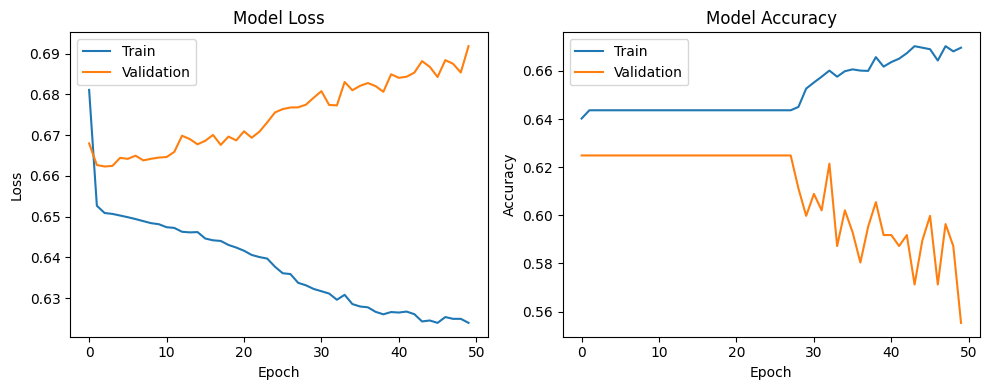

In [34]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Plot training history (loss and accuracy)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Plot training & validation loss values
plt.subplot(121)
plt.plot(fit_model.history['loss'], label='Train')
plt.plot(fit_model.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(122)
plt.plot(fit_model.history['accuracy'], label='Train')
plt.plot(fit_model.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### As Expected from randomly generated data, there is no correlation between the features for the model to learn from. so the validation accuracy is near the random guess at best, and any attempt to make it better results in over fitting.

In [38]:
nn.export("/content/drive/MyDrive/ML /heart_attack_prediction/heart_attack_prediction_random.hdf5")

Saved artifact at '/content/drive/MyDrive/ML /heart_attack_prediction/heart_attack_prediction_random.hdf5'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 33)
  Returns:
    float32 Tensor, shape=(None, 1)
